In [1]:
import os
import numpy as np
import numpy.random as rand
from scipy import signal as sig, interpolate as interp, integrate
import matplotlib.pyplot as mp
import cv2 as cv
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
mp.style.use('ggplot')
mp.rcParams["axes.axisbelow"] = True
mp.rcParams["text.usetex"] = True
mp.rcParams["font.family"] = "serif"
mp.rcParams["figure.figsize"] = (16/2, 9/2)
mp.rcParams["figure.dpi"] = 100
mp.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

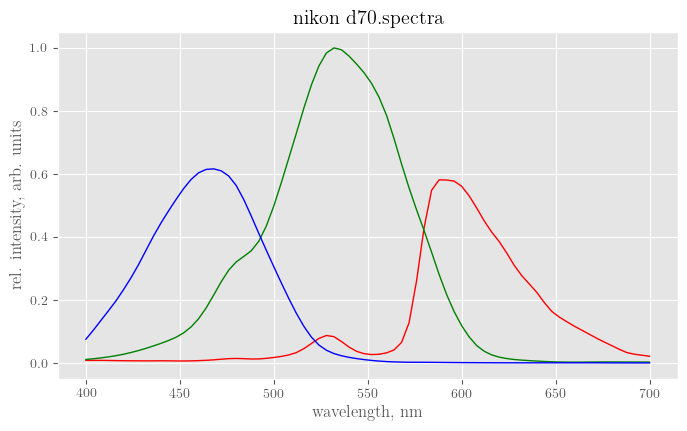

In [3]:
f = 'nikon_d70.spectra'
wl, r, g, b = np.genfromtxt(f).T
mp.plot(wl, r, 'r-', wl, g, 'g-', wl, b, 'b-', lw=1)
mp.title(' '.join(f.split('_')[:2]))
mp.xlabel('wavelength, nm')
mp.ylabel('rel. intensity, arb. units')
mp.savefig('nikond70.png', dpi=300, bbox_inches='tight')
mp.show()

\begin{eqnarray}
    Q_i = \int_{visible} M(\lambda) R(\lambda) S_i(\lambda) d\lambda \\
    DN_i = \frac{\sum M(\lambda) R(\lambda) S_i(\lambda)}{M(\lambda) S_i(\lambda)}
\end{eqnarray}

In [4]:
class ColorRender:
    def loadLight(self, filename, savgol=False):
        if type(filename) == str:
            data = np.genfromtxt(filename, skip_header=4)
        elif type(filename) == np.ndarray:
            data = filename
        else:
            raise NotImplementedError
        self.M_wavelength, self.M_intensity = data.T
        self.M_intensity /= self.M_intensity.max()
        if savgol:
            self.M_int_orig = self.M_intensity.copy()
            self.M_intensity = sig.savgol_filter(self.M_int_orig, 71, 3)
        
    def loadReflectance(self, filename, savgol=False):
        if type(filename) == str:
            data = np.genfromtxt(filename, skip_header=4)
        elif type(filename) == np.ndarray:
            data = filename
        else:
            raise NotImplementedError
        self.R_wavelength, self.R_intensity = data.T
        self.R_intensity /= self.R_intensity.max()
        if savgol:
            self.R_int_orig = self.R_intensity.copy()
            self.R_intensity = sig.savgol_filter(self.R_int_orig, 71, 3)
        
    def loadSensitivity(self, filename):
        if type(filename) == str:
            data = np.genfromtxt(filename)
        elif type(filename) == np.ndarray:
            data = filename
        else:
            raise NotImplementedError
        self.S_wavelength, self.S_R, self.S_G, self.S_B = data.T
        
    def equalizeLengths(self):
        overall_wlmin = max(self.M_wavelength.min(), self.R_wavelength.min(), self.S_wavelength.min())
        overall_wlmax = min(self.M_wavelength.max(), self.R_wavelength.max(), self.S_wavelength.max())
        overall_wllen = max(self.M_wavelength.size, self.R_wavelength.size, self.S_wavelength.size)
        
        R_interp = interp.interp1d(self.S_wavelength, self.S_R)
        G_interp = interp.interp1d(self.S_wavelength, self.S_G)
        B_interp = interp.interp1d(self.S_wavelength, self.S_B)
        emit_interp = interp.interp1d(self.M_wavelength, self.M_intensity)
        refl_interp = interp.interp1d(self.R_wavelength, self.R_intensity)
        
        self.wavelength = np.linspace(overall_wlmin, overall_wlmax, overall_wllen)
        self.M_intensity = emit_interp(self.wavelength)
        self.R_intensity = refl_interp(self.wavelength)
        self.Sr = R_interp(self.wavelength)
        self.Sg = G_interp(self.wavelength)
        self.Sb = B_interp(self.wavelength)
        
    def computeDigiNumber(self, method):
        if method == 'integrate':
            self.DN = np.array([integrate.trapz(self.M_intensity * self.R_intensity * Si, 
                                            self.wavelength)
                            for Si in [self.Sr, self.Sg, self.Sb]])
        elif method == 'sum':
            self.DN = np.array([np.sum(self.M_intensity * self.R_intensity * Si)/
                                np.sum(self.M_intensity * Si)
                            for Si in [self.Sr, self.Sg, self.Sb]])
        else:
            raise NotImplementedError
            
        
    def main(self, kwargs, method, emit_filter=False, refl_filter=False, save=False, savename=None):
        self.loadLight(kwargs.pop('emittance_filename'))
        self.loadReflectance(kwargs.pop('reflectance_filename'))
        self.loadSensitivity(kwargs.pop('sensitivity_filename'))
        self.equalizeLengths()
        self.computeDigiNumber(method)
        
        P = np.dstack([np.ones((512, 512))*n for n in self.DN])
        P = (P * 255).astype('uint8')
        mp.imshow(P)
        mp.axis('off')
        if save:
            cv.imwrite(savename, P)
#         mp.show()

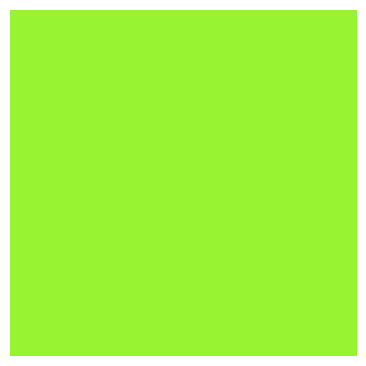

In [5]:
filename_kwargs = dict({'emittance_filename': 'reference_7.txt',
                        'reflectance_filename': 'leaf1_4.txt',
                        'sensitivity_filename': 'nikon_d70.spectra'})
rend = ColorRender()
rend.main(filename_kwargs, 'integrate', False, True, False)
mp.show()

In [6]:
mcc = np.genfromtxt('macbethcolorchecker.csv', delimiter=',', skip_header=1, unpack=True)
wavelength = mcc[0]
mac = mcc[1:-2]
wavd65, intd65 = np.genfromtxt('illuminant_d65.csv', delimiter=',', unpack=True)

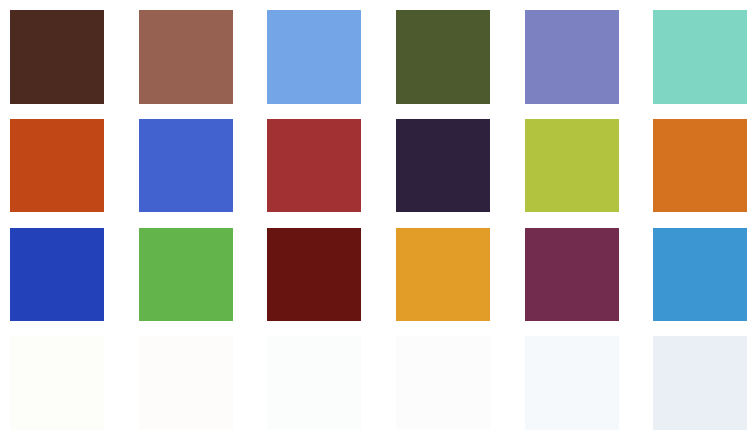

In [7]:
fig = mp.figure(figsize=(16/2,9/2))
for i in range(len(mac)):
    ax = fig.add_subplot(4, 6, i+1)
    filename_kwargs = dict({'emittance_filename': np.array([wavd65, intd65]).T,
                            'reflectance_filename': np.array([wavelength, mac[i]]).T,
                            'sensitivity_filename': 'nikon_d70.spectra'})
    rend = ColorRender()
    rend.main(filename_kwargs, 'sum', False, True, False)
mp.tight_layout()
# mp.savefig('mac_rendered.png', dpi=300, bbox_inches='tight')
mp.show()